In [1]:
import datetime as dt
import pandas as pd
#!pip install yfinance
import yfinance as yf

In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.sql.functions import to_date
from pyspark.ml.evaluation import RegressionEvaluator


In [3]:
# SparkSession başlatma
spark = SparkSession.builder.appName("NVDA Price Prediction").getOrCreate()

24/04/01 06:26:36 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [4]:
# Veriyi yükleme ve DataFrame oluşturma
data = spark.read.csv("file:///home/hduser/Desktop/NVDA/NVDA_histrical_data.csv", header=True, inferSchema=True)

# 'Date' sütununu tarih tipine dönüştürme 
data = data.withColumn("Date", to_date(data["Date"]))

In [5]:
data.show(5)

+----------+-------------------+-------------------+-------------------+-------------------+-------------------+--------+
|      Date|               Open|               High|                Low|              Close|          Adj Close|  Volume|
+----------+-------------------+-------------------+-------------------+-------------------+-------------------+--------+
|1999-03-22| 0.4466150104999542|0.44791701436042786|0.42447900772094727|0.42447900772094727| 0.3893755376338959| 3667200|
|1999-03-23|0.42708298563957214|0.42708298563957214|           0.390625| 0.3984380066394806| 0.3654879927635193|16396800|
|1999-03-24|0.39583298563957214| 0.3984380066394806|0.38020798563957214|0.39583298563957214| 0.3630985617637634| 6086400|
|1999-03-25| 0.3945310115814209|0.41666701436042786|0.39322900772094727|0.40104201436042786|0.36787667870521545| 4032000|
|1999-03-26|            0.40625|             0.4375|            0.40625|0.43619799613952637|0.40012532472610474| 8827200|
+----------+------------

In [6]:
spark.createDataFrame(data.tail(5)).show()

+----------+-----------------+-----------------+-----------------+-----------------+-----------------+--------+
|      Date|             Open|             High|              Low|            Close|        Adj Close|  Volume|
+----------+-----------------+-----------------+-----------------+-----------------+-----------------+--------+
|2024-03-15|869.2999877929688|895.4600219726562|862.5700073242188|878.3699951171875|878.3699951171875|64019300|
|2024-03-18|903.8800048828125|924.0499877929688|870.8499755859375|884.5499877929688|884.5499877929688|66897600|
|2024-03-19|            867.0|905.4400024414062|850.0999755859375|  893.97998046875|  893.97998046875|67217100|
|2024-03-20| 897.969970703125|904.0999755859375|  882.22998046875| 903.719970703125| 903.719970703125|47906300|
|2024-03-21|            923.0|  926.47998046875|904.0499877929688|914.3499755859375|914.3499755859375|48037200|
+----------+-----------------+-----------------+-----------------+-----------------+-----------------+--

In [7]:
# 'Close' dışındaki tüm sütunları at
df_org = data.select("Date", "Close")

# İlk 5 satırı göstermek için
df_org.show(5)


+----------+-------------------+
|      Date|              Close|
+----------+-------------------+
|1999-03-22|0.42447900772094727|
|1999-03-23| 0.3984380066394806|
|1999-03-24|0.39583298563957214|
|1999-03-25|0.40104201436042786|
|1999-03-26|0.43619799613952637|
+----------+-------------------+
only showing top 5 rows



In [8]:
df = df_org

In [9]:
from pyspark.sql.functions import col, count, when

# Her bir sütun için eksik değer sayısını hesaplama
missing_values = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
missing_values.show()

+----+-----+
|Date|Close|
+----+-----+
|   0|    0|
+----+-----+



In [10]:
# 'Close' sütunu ve 'Date' sütunu ile sınırlı DataFrame'i CSV olarak kaydet
#df.write.csv("file:///home/hduser/Desktop/NVDA/NVDA.csv", header=True)


Uyarıları tamamen kapatmanın bir yolu olmasa da, günlükleri daha az ayrıntılı hale getirerek uyarıların gösterilmesini azaltabilirsiniz. Bu, Spark'ın günlük seviyesini ayarlayarak yapılabilir. Örneğin, günlük seviyesini "ERROR" olarak ayarlamak yalnızca hata mesajlarının gösterilmesini sağlayacaktır.

In [11]:
spark.sparkContext.setLogLevel("ERROR")

1. Veri Setinin Yüklenmesi ve Öznitelik Oluşturma

In [12]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lag,col, to_date, dayofweek
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.window import Window
# Spark oturumunu başlatma
spark = SparkSession.builder.appName("Stock Price Forecasting").getOrCreate()

# Gecikmeli öznitelikler ekleyin
for i in range(1, 6):
    df = df.withColumn(f"lag_{i}", lag(col("Close"), i).over(Window.orderBy("Date")))

# Haftanın günü gibi tarih özniteliklerini ekleyin
df = df.withColumn("DayOfWeek", dayofweek(col("Date")))

# Eğitim için kullanılacak özniteliklerin listesini oluştur
input_cols = [f"lag_{i}" for i in range(1, 6)] + ['DayOfWeek']

In [13]:
from pyspark.sql import functions as F

for i in range(1, 6):
    # 'lag' sütunlarını mevcut 'Close' değeriyle doldurun
    df = df.withColumn(f"lag_{i}", F.coalesce(df[f"lag_{i}"], df["Close"]))

In [14]:
#df.show(6)

In [15]:
from pyspark.sql.functions import dayofweek
# 'DayOfWeek' sütunu için eksik değerleri doldurun
#df = df.withColumn('DayOfWeek', dayofweek(df['Date']))
# 'DayOfWeek' sütunu için `null` değerleri kontrol edin ve doldurun
#df = df.na.fill({'DayOfWeek': 0})

# VectorAssembler'ı tekrar çalıştırın
vectorAssembler = VectorAssembler(inputCols=input_cols, outputCol='features')
df = vectorAssembler.transform(df)

# Veri setini eğitim ve test olarak ayırma
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)


2. Model Eğitimi ve Katsayıların Gözlemlenmesi

In [16]:
from pyspark.ml.regression import LinearRegression

# Modeli tanımla ve eğit
lr = LinearRegression(featuresCol="features", labelCol="Close")
model = lr.fit(train_df)

# Eğitim ve test setleri üzerinde tahminler yap
train_predictions = model.transform(train_df)
test_predictions = model.transform(test_df)

# Model katsayılarını ve intercept değerini yazdır
print("Intercept:", model.intercept)
print("Coefficients:")
for i, coeff in enumerate(model.coefficients):
    print(f"lag_{i+1} coefficient: {coeff}")


Intercept: 0.04988244110402498
Coefficients:
lag_1 coefficient: 0.9337373195024947
lag_2 coefficient: -0.04444383555935839
lag_3 coefficient: 0.13583450907517358
lag_4 coefficient: -0.042829205807827314
lag_5 coefficient: 0.022714581792605455
lag_6 coefficient: -0.03340973729783707


3. Model Değerlendirme (RMSE ve MSE)

In [17]:
from pyspark.ml.evaluation import RegressionEvaluator

# RMSE ve MSE değerlendirici tanımla ve hesapla
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Close")

train_rmse = evaluator.evaluate(train_predictions, {evaluator.metricName: "rmse"})
test_rmse = evaluator.evaluate(test_predictions, {evaluator.metricName: "rmse"})
train_mse = evaluator.evaluate(train_predictions, {evaluator.metricName: "mse"})
test_mse = evaluator.evaluate(test_predictions, {evaluator.metricName: "mse"})

print(f"Train RMSE: {train_rmse}, Train MSE: {train_mse}")
print(f"Test RMSE: {test_rmse}, Test MSE: {test_mse}")


Train RMSE: 3.81371978892459, Train MSE: 14.544458628435018
Test RMSE: 3.0538706461634777, Test MSE: 9.326125923498937


4. Gelecekteki 5 Gün İçin Tahminlerin Yapılması

In [18]:
import datetime as dt

last_row = train_df.orderBy(F.desc("Date")).first()
today_date = last_row["Date"]
#end = dt.datetime.now()
end = dt.datetime.now().date()
# Hafta içi ve toplam günlerin sayısını saklamak için bir değişken tanımla 
# Bu degiskenlere gelecek degerler bir gun oncenin olacagi icin -1'den baslatiyoruz
weekdays_count = -1
totol_days = -1
# Tarih aralığını döngüye alarak her gün için hafta içi olup olmadığını kontrol et
current_date = today_date
while current_date < end:
    totol_days += 1
    # Eğer gün hafta içi ise, weekdays_count değişkenini artır
    if current_date.weekday() < 5:  # Pazartesi (0) - Cuma (4)
        weekdays_count += 1
    # Bir sonraki günü al
    current_date += dt.timedelta(days=1)

# Hafta içi günlerin sayısını yazdır
print("Hafta içi günlerin toplam sayısı:", weekdays_count)
print("Toplam geçen gün sayısı:", totol_days)

Hafta içi günlerin toplam sayısı: 6
Toplam geçen gün sayısı: 10


In [19]:
from datetime import datetime, timedelta
# Gelecek tarihler için bir liste oluşturun, hafta sonlarını atlayın
future_dates = []
for i in range(1, totol_days+1):
    next_day = today_date + timedelta(days=i)
    if next_day.weekday() < 5:  # 0: Pazartesi, ..., 4: Cuma
        future_dates.append(next_day)
future_dates

[datetime.date(2024, 3, 22),
 datetime.date(2024, 3, 25),
 datetime.date(2024, 3, 26),
 datetime.date(2024, 3, 27),
 datetime.date(2024, 3, 28),
 datetime.date(2024, 3, 29)]

In [20]:
# Modelin en son tahminlerinden ve bilinen değerlerden yeni gecikmeli öznitelikler yaratma
last_known_values = [last_row["Close"]] + [last_row[f"lag_{i}"] for i in range(1, 5)]

In [21]:
from pyspark.sql.functions import lit, array
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import to_date, max
from datetime import datetime, timedelta

# Modeli ve son bilinen verileri yükleyin
#trained_model = # Eğitilmiş modelinizin yüklendiği yer
#last_known_values = # Son bilinen lag ve close değerleri


# Tahmin yapmak istediğiniz gün sayısını belirleyin
future_days = len(future_dates)  # Örneğin, future_dates uzunlugu kadar tahmin etmek istiyorsanız

# Veri setindeki en son tarihi al
last_date_row = df.select(max(to_date("Date"))).collect()
current_date = last_date_row[0][0]
#current_date = datetime.now()  # Mevcut tarihi kullanarak tahminler yapın

# Gelecek tarihler için boş bir DataFrame oluşturun
#future_dates = [current_date + timedelta(days=i) for i in range(1, future_days + 1)]
future_predictions = []


# Örnek olarak, eğer modeliniz 5 gecikme özelliği kullanıyorsa (lag_1, lag_2, ... lag_5),
# ve last_known_values son bilinen 'Close' değeri ve 5 gecikme özelliğini içeriyorsa:
lag_features = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']

# Bu değerleri kullanarak yeni özellikler vektörünü oluşturun
#new_features = [last_known_values[i] for i in lag_features]

# Döngü ile tahminleri yapın
for future_date in future_dates:
    # Yeni özellikler vektörünü oluşturun
    new_features = last_known_values[-len(lag_features):] + [last_known_values[0]]
    new_features_vector = Vectors.dense(new_features)
    
    # Yeni veri setini oluşturun ve tahmin yapın
    df_to_predict = spark.createDataFrame([(future_date, new_features_vector)], ["Date", "features"])
    prediction = model.transform(df_to_predict)
    
    # Tahmin edilen değeri alın ve sonuç listesine ekleyin
    predicted_close = prediction.select("prediction").collect()[0]["prediction"]
    future_predictions.append((future_date, predicted_close))
    
    # Sonraki tahmin için 'lag' değerlerini güncelleyin
    last_known_values = new_features[1:] + [predicted_close]

# Tahminleri içeren DataFrame'i oluşturun
predictions_df = spark.createDataFrame(future_predictions, ["Date", "Predicted_Close"])
predictions_df.show()


+----------+-----------------+
|      Date|  Predicted_Close|
+----------+-----------------+
|2024-03-22|886.6001688734106|
|2024-03-25|865.5773379209504|
|2024-03-26|851.4134418426622|
|2024-03-27|856.2187728958244|
|2024-03-28|834.7049997172702|
|2024-03-29|821.4150077861905|
+----------+-----------------+



In [22]:
spark.createDataFrame(df_org.tail(5)).show()

+----------+-----------------+
|      Date|            Close|
+----------+-----------------+
|2024-03-15|878.3699951171875|
|2024-03-18|884.5499877929688|
|2024-03-19|  893.97998046875|
|2024-03-20| 903.719970703125|
|2024-03-21|914.3499755859375|
+----------+-----------------+



In [23]:
import datetime as dt
import pandas as pd
#pip install yfinance
import yfinance as yf
import numpy as np

In [24]:
end = dt.datetime.now()
#end = dt.datetime(2024,3,27)
start = dt.datetime(2024,3,22)
start,end

(datetime.datetime(2024, 3, 22, 0, 0),
 datetime.datetime(2024, 4, 1, 6, 26, 45, 138369))

In [25]:
df_real = yf.download("NVDA",start,end)
df_real_close = df_real.drop(columns=["Open","High","Low","Adj Close","Volume"])
df_real_close

[*********************100%%**********************]  1 of 1 completed


,Close
Date,
2024-03-22,942.890015
2024-03-25,950.020020
2024-03-26,925.609985
2024-03-27,902.500000
2024-03-28,903.559998


In [26]:
# Spark DataFrame'ini pandas DataFrame'ine dönüştürme
predictions_pandas_df = predictions_df.toPandas()
# 'Date' sütununu index olarak atama
predictions_pandas_df = predictions_pandas_df.set_index('Date')
predictions_pandas_df

,Predicted_Close
Date,
2024-03-22,886.600169
2024-03-25,865.577338
2024-03-26,851.413442
2024-03-27,856.218773
2024-03-28,834.705000
2024-03-29,821.415008


In [27]:
#!pip install plotly
import plotly.offline as pyo
pyo.init_notebook_mode(connected = True)
pd.options.plotting.backend = "plotly"

In [28]:
# Index üzerinden birleştirme yapın
# Bu, aynı tarihlerdeki verileri yan yana getirecektir
merged_df = df_real.join(predictions_pandas_df, how='inner')
merged_df

,Open,High,Low,Close,Adj Close,Volume,Predicted_Close
Date,,,,,,,
2024-03-22,911.409973,947.780029,908.340027,942.890015,942.890015,58521500,886.600169
2024-03-25,939.409973,967.659973,935.099976,950.020020,950.020020,55213600,865.577338
2024-03-26,958.510010,963.750000,925.020020,925.609985,925.609985,51364800,851.413442
2024-03-27,931.119995,932.400024,891.229980,902.500000,902.500000,58606700,856.218773
2024-03-28,900.000000,913.000000,891.929993,903.559998,903.559998,43521200,834.705000


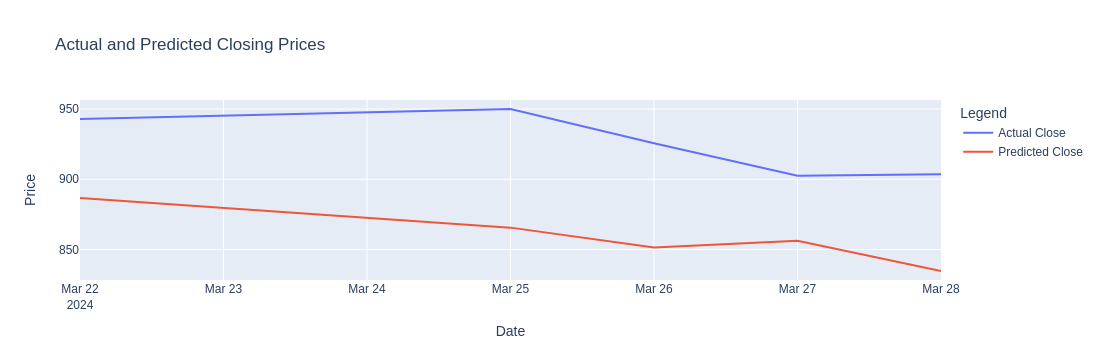

In [29]:
import plotly.graph_objs as go

# Create Plotly Scatter objects
trace1 = go.Scatter(
    x=merged_df.index,
    y=merged_df['Close'],
    mode='lines',
    name='Actual Close'
)

trace2 = go.Scatter(
    x=merged_df.index,
    y=merged_df['Predicted_Close'],
    mode='lines',
    name='Predicted Close'
)

# Create and show the combined graph
fig = go.Figure(data=[trace1, trace2])
fig.update_layout(
    title='Actual and Predicted Closing Prices',
    xaxis_title='Date',
    yaxis_title='Price',
    legend_title='Legend'
)

fig.show()


In [30]:
# Hata metriklerini hesaplayın
errors = merged_df['Close'] - merged_df['Predicted_Close']
mae = np.mean(np.abs(errors))
mse = np.mean(np.square(errors))
rmse = np.sqrt(mse)

print(f"MAE: {mae}") # Mean Absolute Error - MAE
print(f"MSE: {mse}") # Mean Squared Error - MSE
print(f"RMSE: {rmse}") # Root Mean Squared Error - RMSE

MAE: 66.0130591679452
MSE: 4537.440598715966
RMSE: 67.36052700740966


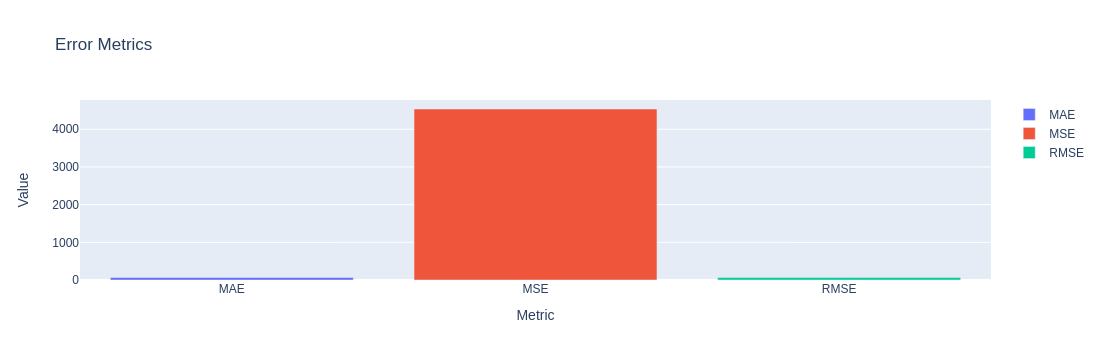

In [31]:
import plotly.graph_objs as go

# Örnek veriler
hata = {
    'Metrics': ['MAE', 'MSE', 'RMSE'],
    'Values': [mae, mse, rmse]
}
# Bar grafiği oluşturun ve efsane (legend) özelliğini aktifleştirin
traces = []
for metric, value in zip(hata['Metrics'], hata['Values']):
    traces.append(go.Bar(x=[metric], y=[value], name=metric))

fig = go.Figure(data=traces)
fig.update_layout(
    title='Error Metrics',
    xaxis_title='Metric',
    yaxis_title='Value',
    showlegend=True  # Efsaneyi göster
)

# Grafiği göster
fig.show()

# ARIMA

In [32]:
df_arima = pd.read_csv("file:///home/hduser/Desktop/NVDA/NVDA.csv")

In [33]:
df_arima.head()

,Date,Close
0,1999-03-22,0.424479
1,1999-03-23,0.398438
2,1999-03-24,0.395833
3,1999-03-25,0.401042
4,1999-03-26,0.436198


In [34]:
# Tarih sütununu datetime tipine çevirelim ve indeks olarak ayarlayalım
df_arima["Date"] = pd.to_datetime(df_arima["Date"])
df_arima.set_index("Date", inplace=True)

# Veri setinin son halini gösterelim
df_arima.head()


,Close
Date,
1999-03-22,0.424479
1999-03-23,0.398438
1999-03-24,0.395833
1999-03-25,0.401042
1999-03-26,0.436198


In [35]:
#!pip install statsmodels

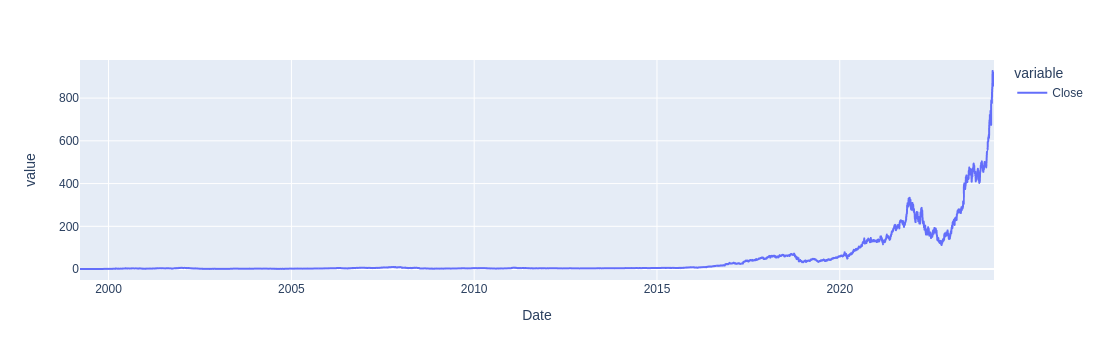

In [36]:
df_arima["Close"].plot()

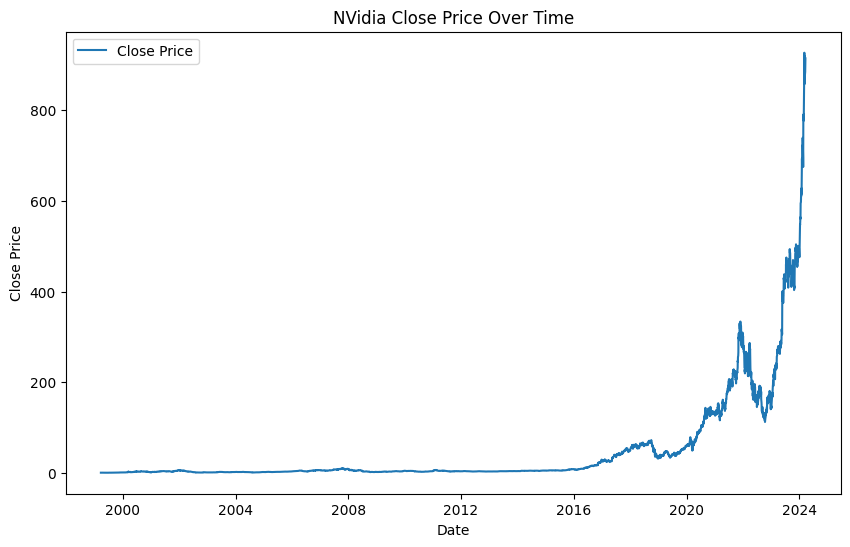

In [37]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Zaman serisinin grafiğini çizelim
plt.figure(figsize=(10, 6))
plt.plot(df_arima.index, df_arima["Close"], label="Close Price")
plt.title("NVidia Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

In [38]:
# Durağanlık testi yapalım (Augmented Dickey-Fuller testi)
adf_test = adfuller(df_arima["Close"])
adf_test_output = {"Test Statistic": adf_test[0], "p-value": adf_test[1], "Critical Values": adf_test[4]}

adf_test_output


{'Test Statistic': 5.155957114554979,
 'p-value': 1.0,
 'Critical Values': {'1%': -3.43139554655334,
  '5%': -2.8620020389491527,
  '10%': -2.5670159403767285}}

In [39]:
# İlk farkı alalım
df_diff = df_arima["Close"].diff().dropna()


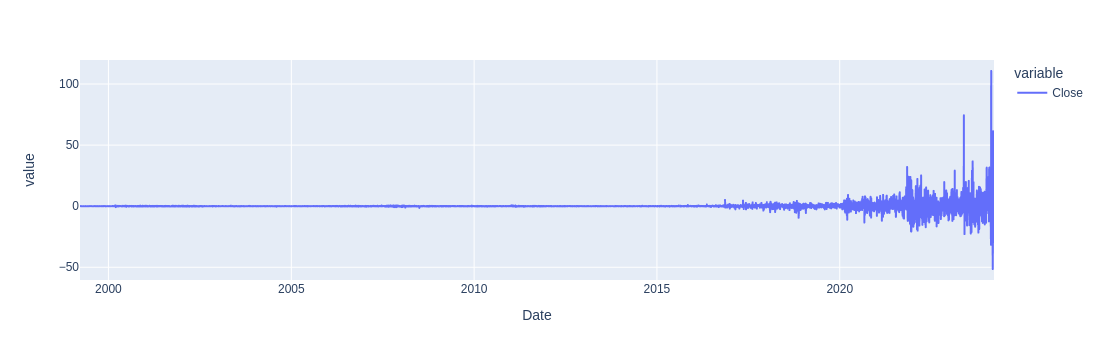

In [40]:
df_diff.plot()

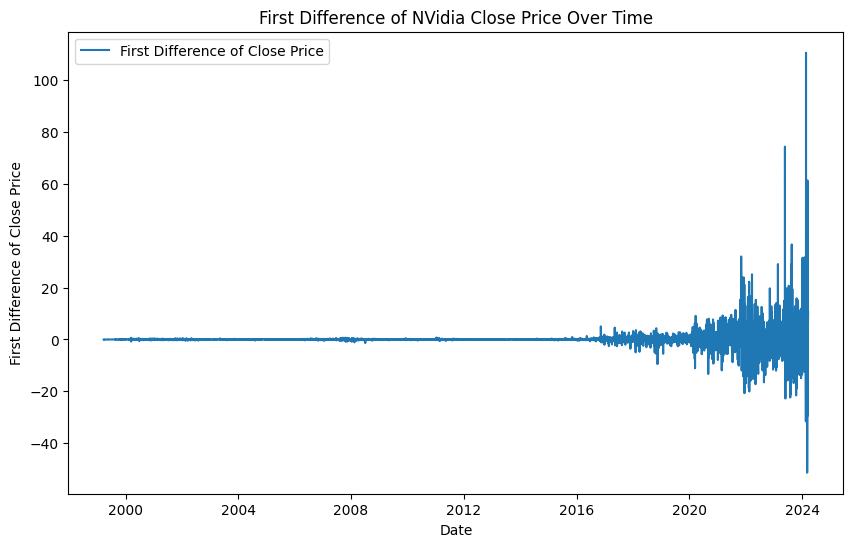

In [41]:
# İlk farkın grafiğini çizelim
plt.figure(figsize=(10, 6))
plt.plot(df_diff.index, df_diff, label="First Difference of Close Price")
plt.title("First Difference of NVidia Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("First Difference of Close Price")
plt.legend()
plt.show()

In [42]:
# Yeniden durağanlık testi yapalım
adf_test_diff = adfuller(df_diff)
adf_test_diff_output = {"Test Statistic": adf_test_diff[0], "p-value": adf_test_diff[1], "Critical Values": adf_test_diff[4]}

adf_test_diff_output


{'Test Statistic': -5.757858629267697,
 'p-value': 5.76359951481798e-07,
 'Critical Values': {'1%': -3.431395379411139,
  '5%': -2.8620019651000943,
  '10%': -2.567015901065109}}

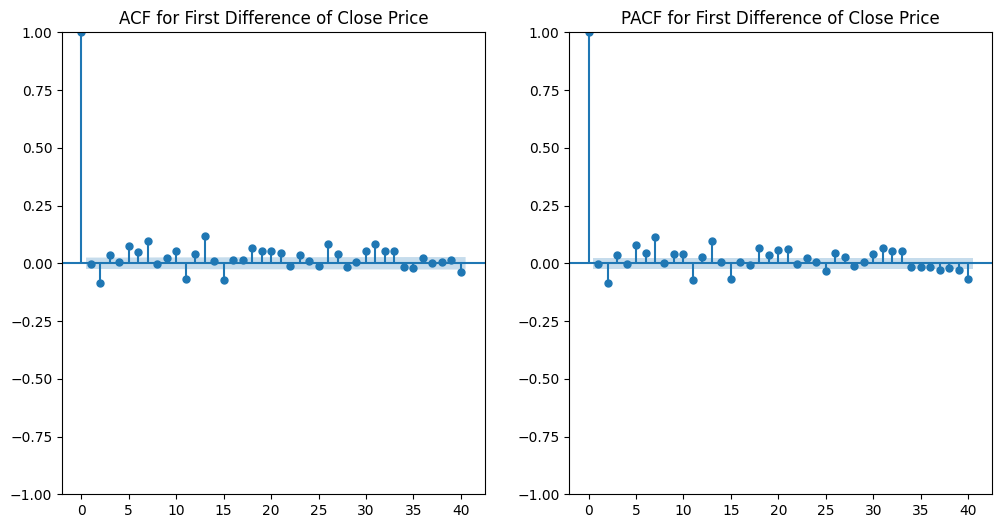

In [43]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF ve PACF grafiklerini çizdirelim
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Otomatik Çapraz Korelasyon Fonksiyonu (ACF)
plot_acf(df_diff, ax=ax1, lags=40, alpha=0.05)
ax1.set_title("ACF for First Difference of Close Price")

# Kısmi Otomatik Çapraz Korelasyon Fonksiyonu (PACF)
plot_pacf(df_diff, ax=ax2, lags=40, alpha=0.05)
ax2.set_title("PACF for First Difference of Close Price")

plt.show()


In [44]:
from statsmodels.tsa.arima.model import ARIMA
df_arima = df_arima.asfreq('B')
# ARIMA modelini kurma ve eğitme
model = ARIMA(df_arima["Close"], order=(1, 1, 1))

model_fit = model.fit()

# Model özeti
model_summary = model_fit.summary()

print(model_summary)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 6524
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -17217.616
Date:                Mon, 01 Apr 2024   AIC                          34441.231
Time:                        06:26:48   BIC                          34461.581
Sample:                    03-22-1999   HQIC                         34448.268
                         - 03-21-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9080      0.006   -158.403      0.000      -0.919      -0.897
ma.L1          0.9537      0.005    206.723      0.000       0.945       0.963
sigma2        13.5654      0.030    446.404      0.0

In [45]:
# Pandas kullanarak iş günleri sayısını ve toplam gün sayısını hesaplayacağız
import pandas as pd
import datetime as dt


start_arima = df_arima.index.max()

# Bugünün tarihini alalım
end_arima = pd.to_datetime("today").normalize()  # Saat bilgisi olmadan bugünün tarihi

# İş günlerini hesaplayalım
business_days = pd.bdate_range(start=start_arima, end=end_arima)

# İş günleri ve toplam gün sayısını -1 ile başlatalım çünkü başlangıç gününü saymıyoruz
weekdays_count_arima = len(business_days) - 1
total_days_arima = (end_arima - start_arima).days - 1

weekdays_count_arima, total_days_arima


(7, 10)

In [46]:
forecast_steps = weekdays_count_arima # sonraki is gunleri 
# Sonraki 6 iş günü için tahmin yapma
forecast = model_fit.forecast(steps=forecast_steps)

# Doğru tarih aralığını ve tahminleri alalım
forecast_dates = pd.date_range(start=df_arima.index[-1], periods=forecast_steps+1, freq='B')
forecast_values = model_fit.get_forecast(steps=forecast_steps-1).predicted_mean

# Uyuşmazlık olmaması için tarihlerin ve tahminlerin sayısının aynı olduğundan emin olalım
forecast_dates = forecast_dates[1:]  # İlk tarihi hariç tutuyoruz çünkü tahmin başlangıcı mevcut verinin sonrası olmalı

# Sonuçları bir DataFrame'e dönüştürüyoruz
df_arima_forecast = pd.DataFrame({"Predicted_Close": forecast_values })
df_arima_forecast.rename_axis("Date", inplace=True)
df_arima_forecast

,Predicted_Close
Date,
2024-03-22,915.961616
2024-03-25,914.498229
2024-03-26,915.827000
2024-03-27,914.620462
2024-03-28,915.716012
2024-03-29,914.721241


In [47]:
df_real = yf.download("NVDA",start,end_arima)
df_real_arima = df_real.drop(columns=["Open","High","Low","Adj Close","Volume"])
df_real_arima

[*********************100%%**********************]  1 of 1 completed


,Close
Date,
2024-03-22,942.890015
2024-03-25,950.020020
2024-03-26,925.609985
2024-03-27,902.500000
2024-03-28,903.559998


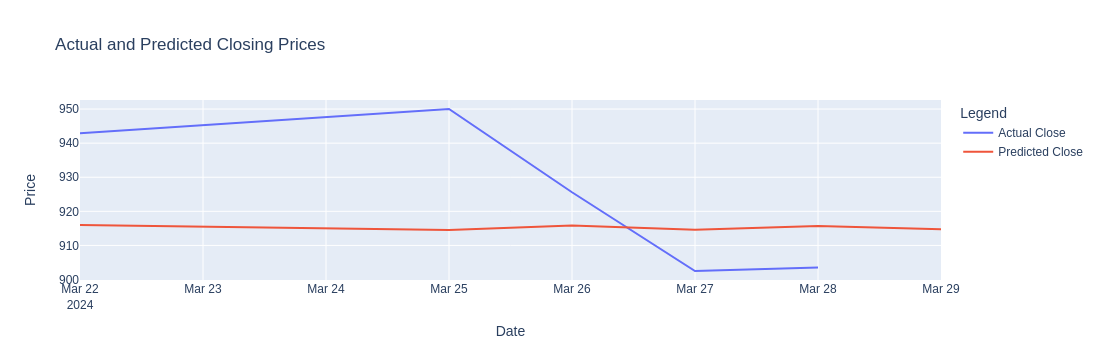

In [48]:
import plotly.graph_objs as go

# Create Plotly Scatter objects
trace_arima_actual = go.Scatter(
    x=df_real_arima.index,
    y=df_real_arima['Close'],
    mode='lines',
    name='Actual Close'
)

trace_arima_predicted = go.Scatter(
    x=df_arima_forecast.index,
    y=df_arima_forecast['Predicted_Close'],
    mode='lines',
    name='Predicted Close'
)

# Create and show the combined graph
fig = go.Figure(data=[trace_arima_actual, trace_arima_predicted])
#fig = go.Figure(data=[trace_arima_actual])
fig.update_layout(
    title='Actual and Predicted Closing Prices',
    xaxis_title='Date',
    yaxis_title='Price',
    legend_title='Legend'
)

fig.show()


In [49]:
# Index üzerinden birleştirme yapın
# Bu, aynı tarihlerdeki verileri yan yana getirecektir
merged_df_arima = df_real_arima.join(df_arima_forecast, how='inner')
merged_df_arima

,Close,Predicted_Close
Date,,
2024-03-22,942.890015,915.961616
2024-03-25,950.020020,914.498229
2024-03-26,925.609985,915.827000
2024-03-27,902.500000,914.620462
2024-03-28,903.559998,915.716012


In [50]:
# Hata metriklerini hesaplayın
errors = merged_df_arima['Close'] - merged_df_arima['Predicted_Close']
mae_arima = np.mean(np.abs(errors))
mse_arima = np.mean(np.square(errors))
rmse_arima = np.sqrt(mse_arima)

print(f"MAE: {mae_arima}") # Mean Absolute Error - MAE
print(f"MSE: {mse_arima}") # Mean Squared Error - MSE
print(f"RMSE: {rmse_arima}") # Root Mean Squared Error - RMSE

MAE: 19.301929952539943
MSE: 475.46345970015153
RMSE: 21.805124620147247


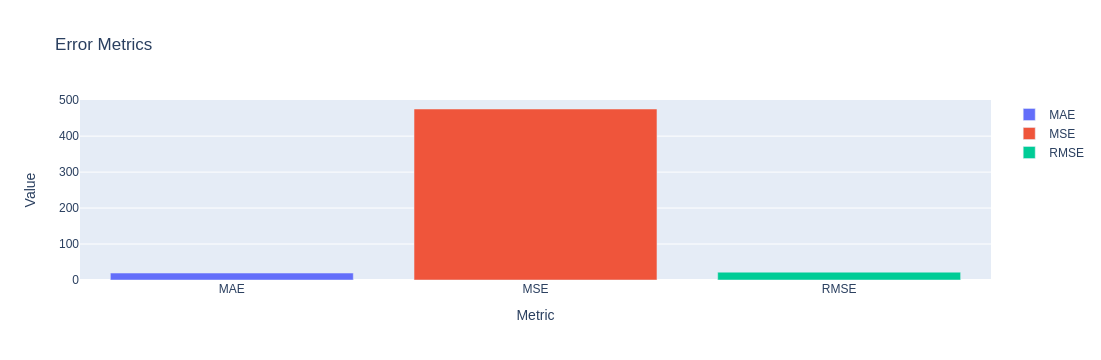

In [51]:
import plotly.graph_objs as go

hata_arima = {
    'Metrics': ['MAE', 'MSE', 'RMSE'],
    'Values': [mae_arima, mse_arima, rmse_arima]
}

# Her bir metrik için bir go.Bar oluşturup bir listeye ekleyin
traces_arima = [go.Bar(x=[metric], y=[value], name=metric) for metric, value in zip(hata_arima['Metrics'], hata_arima['Values'])]

# go.Figure ile grafiği oluşturun
fig = go.Figure(data=traces_arima)
fig.update_layout(
    title='Error Metrics',
    xaxis_title='Metric',
    yaxis_title='Value',
    showlegend=True  # Efsaneyi göster
)

# Grafiği göster
fig.show()


# LSTM

In [52]:
df_LSTM = pd.read_csv("file:///home/hduser/Desktop/NVDA/NVDA.csv")

In [53]:
df_LSTM.head()

,Date,Close
0,1999-03-22,0.424479
1,1999-03-23,0.398438
2,1999-03-24,0.395833
3,1999-03-25,0.401042
4,1999-03-26,0.436198


In [54]:
# Tarih sütununu datetime tipine çevirelim ve indeks olarak ayarlayalım
df_LSTM["Date"] = pd.to_datetime(df_LSTM["Date"])
df_LSTM.set_index("Date", inplace=True)

# Veri setinin son halini gösterelim
df_LSTM.head()


,Close
Date,
1999-03-22,0.424479
1999-03-23,0.398438
1999-03-24,0.395833
1999-03-25,0.401042
1999-03-26,0.436198


In [55]:
df_LSTM.isnull().sum()

Close    0
dtype: int64

In [56]:
#!pip install scikit-learn
#!pip install keras
#!pip install tensorflow

In [57]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df_LSTM)

# Eğitim ve test setlerine ayırma
train_size = int(len(df_scaled) * 0.80)
test_size = len(df_scaled) - train_size
train, test = df_scaled[0:train_size, :], df_scaled[train_size:len(df_scaled), :]


In [58]:
import numpy as np

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)


In [59]:
#pip install tensorflow
#pip install tensorflow==2.16.1

In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
# Örnek olarak, eğer her bir zaman adımında sadece 1 özellik (örneğin sadece kapanış fiyatı) varsa:
input_shape = (look_back, 1)

# Eğer birden fazla özellik varsa (örneğin hem kapanış fiyatı hem de hacim):
#input_shape = (look_back, 2)  # Bu, kullanılan özellik sayısına göre değişebilir

# Modelinizi oluşturun
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

2024-04-01 06:26:49.387341: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-01 06:26:49.479647: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-01 06:26:50.005051: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-04-01 06:26:50.383803: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-01 06:26:50.439106: 

In [61]:
# Modelinizi eğitim verileri ile eğitin
# Bu kod bloğu, X_train'in ve y_train'in uygun şekilde hazırlandığını varsayar
model.fit(X_train, y_train, epochs=100, batch_size=8, verbose=2)

Epoch 1/100
629/629 - 2s - 3ms/step - loss: 5.5350e-05
Epoch 2/100
629/629 - 1s - 843us/step - loss: 4.3569e-07
Epoch 3/100
629/629 - 1s - 859us/step - loss: 4.8746e-07
Epoch 4/100
629/629 - 1s - 848us/step - loss: 6.6299e-07
Epoch 5/100
629/629 - 1s - 835us/step - loss: 5.7151e-07
Epoch 6/100
629/629 - 1s - 843us/step - loss: 5.8392e-07
Epoch 7/100
629/629 - 1s - 921us/step - loss: 6.1802e-07
Epoch 8/100
629/629 - 1s - 901us/step - loss: 5.6827e-07
Epoch 9/100
629/629 - 1s - 895us/step - loss: 6.7558e-07
Epoch 10/100
629/629 - 1s - 911us/step - loss: 5.6695e-07
Epoch 11/100
629/629 - 1s - 882us/step - loss: 6.6741e-07
Epoch 12/100
629/629 - 1s - 884us/step - loss: 5.7798e-07
Epoch 13/100
629/629 - 1s - 923us/step - loss: 5.6923e-07
Epoch 14/100
629/629 - 1s - 955us/step - loss: 7.0569e-07
Epoch 15/100
629/629 - 1s - 897us/step - loss: 4.8641e-07
Epoch 16/100
629/629 - 1s - 846us/step - loss: 5.4461e-07
Epoch 17/100
629/629 - 1s - 854us/step - loss: 6.1237e-07
Epoch 18/100
629/629 - 1s

In [62]:
# Tahmin yap
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Ölçeklendirmeyi tersine çevir
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([y_test])

# Model performansını değerlendir
train_score = np.sqrt(np.mean((y_train[0] - train_predict[:, 0])**2))
test_score = np.sqrt(np.mean((y_test[0] - test_predict[:, 0])**2))
print(f'Train Score: {train_score:.2f} RMSE')
print(f'Test Score: {test_score:.2f} RMSE')

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step
Train Score: 16.83 RMSE
Test Score: 204.61 RMSE


In [63]:
#!pip install keras-tuner

In [64]:
from tensorflow import keras
from kerastuner.tuners import RandomSearch

# Model oluşturmak için fonksiyon
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.LSTM(
        units=hp.Int('units', min_value=32, max_value=256, step=32),
        return_sequences=True,
        input_shape=(X_train.shape[1], 1)))  # X_train'in özellik sayısına bağlı olarak şekil değişebilir
    model.add(keras.layers.Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(keras.layers.Dense(units=1))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='mean_squared_error',
        metrics=['mean_squared_error'])
    return model

# Tuner'ı tanımla
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='keras_tuner_example' )

Reloading Tuner from my_dir/keras_tuner_example/tuner0.json


/tmp/ipykernel_154155/785552042.py:2: DeprecationWarning:

`import kerastuner` is deprecated, please use `import keras_tuner`.



In [65]:
# Tuner ile hiperparametre aramasını başlat
tuner.search(X_train, y_train, epochs=20, validation_split=0.2, callbacks=[keras.callbacks.EarlyStopping('val_loss', patience=5)])

In [66]:
best_hps = tuner.get_best_hyperparameters()[0]
print(f"En iyi hiperparametreler: {best_hps.values}")
#print(f"En iyi kayıp değeri (val_loss): {tuner.results_summary()}")

En iyi hiperparametreler: {'units': 64, 'dropout': 0.0, 'learning_rate': 0.001}


In [67]:
# En iyi hiperparametreleri al ve modeli yeniden oluştur
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = build_model(best_hps)
model.fit(X_train, y_train, epochs=50, validation_split=0.2)


Epoch 1/50


/home/hduser/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.4085e-06 - mean_squared_error: 4.4085e-06 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 2/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6793e-06 - mean_squared_error: 3.6793e-06 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 3/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.5167e-06 - mean_squared_error: 3.5167e-06 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 4/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.5937e-06 - mean_squared_error: 3.5936e-06 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 5/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7907e-06 - mean_squared_error: 3.7908e-06 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 6/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6925e-06 - mean_squared_error: 3.6925e-06 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 7/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.7010e-06 - me

In [68]:
# Tahmin yap
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Ölçeklendirmeyi tersine çevir
#train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([y_train])
#test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([y_test])

# Model performansını değerlendir
train_score = np.sqrt(np.mean((y_train[0] - train_predict[:, 0])**2))
test_score = np.sqrt(np.mean((y_test[0] - test_predict[:, 0])**2))
print(f'Train Score: {train_score:.4f} RMSE')
print(f'Test Score: {test_score:.4f} RMSE')

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
Train Score: 0.0037 RMSE
Test Score: 0.0425 RMSE


In [69]:
model.save("modelim.h5")

In [70]:
df_real_close

,Close
Date,
2024-03-22,942.890015
2024-03-25,950.020020
2024-03-26,925.609985
2024-03-27,902.500000
2024-03-28,903.559998


In [71]:
df_LSTM.tail()

,Close
Date,
2024-03-15,878.369995
2024-03-18,884.549988
2024-03-19,893.979980
2024-03-20,903.719971
2024-03-21,914.349976


In [72]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

In [93]:
# Pandas kullanarak iş günleri sayısını ve toplam gün sayısını hesaplayacağız
import pandas as pd
import datetime as dt


start_LSTM = df_LSTM.index.max()
start_LSTM = start_LSTM + pd.Timedelta(days=1)

# Bugünün tarihini alalım
end_LSTM = pd.to_datetime("today").normalize()  # Saat bilgisi olmadan bugünün tarihi

# İş günlerini hesaplayalım
business_days_LSTM = pd.bdate_range(start=start_LSTM, end=end_LSTM)

# İş günleri ve toplam gün sayısını -1 ile başlatalım çünkü başlangıç gününü saymıyoruz
weekdays_count_LSTM = len(business_days_LSTM) - 1
total_days_LSTM = (end_LSTM - start_LSTM).days - 1

weekdays_count_LSTM, total_days_LSTM


(6, 9)

In [104]:
# Ensure the closing prices are in the form of a numpy array
close_prices = df_LSTM["Close"].values.reshape(-1, 1)

# Normalize the closing prices using the loaded scaler
normalized_data = scaler.transform(close_prices)

# Function to predict the next n days
def predict_next_n_days(model, normalized_data, look_back, num_days):
    predictions = []
    input_batch = normalized_data[-look_back:].reshape((1, look_back, 1))
    
    for _ in range(num_days):
        # Predict the next closing price
        predicted_normalized_value = model.predict(input_batch)
        # Reshape from 3D to 2D
      
        # Inverse transform the normalized prediction to get the actual predicted closing price
        predicted_value = scaler.inverse_transform(predicted_normalized_value)
        predictions.append(predicted_value[0, 0])
        
        # Update the input batch to include the new prediction
        input_batch = np.append(input_batch[:, 1:, :], predicted_normalized_value.reshape((1, 1, 1)), axis=1)
    
    return predictions


/home/hduser/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



In [105]:
# Predict the closing prices for the next 6 days
look_back = 10  # Adjust this to match the look_back period your model was trained on
predicted_prices = predict_next_n_days(model, normalized_data, look_back, weekdays_count_LSTM)

# Get the last known date from the dataset
start_date = df_LSTM.index[-1]
start_date = last_date + pd.Timedelta(days=1)

# Generate dates for the predictions
predicted_dates = pd.date_range(start=start_LSTM, periods=weekdays_count_LSTM, freq='B')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


ValueError: cannot reshape array of size 10 into shape (1,1,1)

In [103]:
# Create the DataFrame
predictions_df = pd.DataFrame({
    'Predicted_Close': predicted_prices
}, index=predicted_dates)

# Rename the index to "Date"
predictions_df.index.name = 'Date'

# Format the index as a date string for display
predictions_df.index = predictions_df.index.strftime('%Y-%m-%d')

print(predictions_df)


NameError: name 'predicted_prices' is not defined

In [109]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
import joblib

# Ensure the closing prices are in the form of a numpy array
close_prices = df_LSTM["Close"].values.reshape(-1, 1)

# Normalize the closing prices using the loaded scaler
normalized_data = scaler.transform(close_prices)

# Function to predict the next n days
def predict_next_n_days(model, normalized_data, look_back, num_days):
    predictions = []
    input_batch = normalized_data[-look_back:].reshape((1, look_back, 1))
    
    for _ in range(num_days):
        # Predict the next closing price3
        predicted_normalized_value = model.predict(input_batch)
        # Reshape from 3D to 2D
        predicted_normalized_value_2d = predicted_normalized_value.reshape(-1, 1)
        
        # Inverse transform the normalized prediction to get the actual predicted closing price
        predicted_value = scaler.inverse_transform(predicted_normalized_value_2d)
        predictions.append(predicted_value[0, 0])
        
        # Update the input batch to include the new prediction
        input_batch = np.append(input_batch[:, 1:, :], predicted_normalized_value.reshape((1, 1, 1)), axis=1)
    
    return predictions

# Predict the closing prices for the next 6 days
look_back = 10  # Adjust this to match the look_back period your model was trained on
predicted_prices = predict_next_n_days(model, normalized_data, look_back, weekdays_count_LSTM)

# Get the last known date from the dataset
last_date = df_LSTM.index[-1]  # Make sure this is a pandas Timestamp
start_date = last_date + pd.Timedelta(days=1)

# Generate dates for the predictions
predicted_dates = pd.date_range(start=start_date, periods=weekdays_count_LSTM, freq='B')

# Create the DataFrame with predictions and dates
predictions_df = pd.DataFrame({
    'Predicted_Close': predicted_prices
}, index=predicted_dates)

# Set the index name to 'Date' and format it for display
predictions_df.index.name = 'Date'
predictions_df.index = predictions_df.index.strftime('%Y-%m-%d')

# Display the DataFrame
predictions_df


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/home/hduser/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



ValueError: cannot reshape array of size 10 into shape (1,1,1)